###In this notebook i build Deep Convolutional GAN
---

*   Orginal Paper 🗒 -- https://arxiv.org/pdf/1511.06434v1.pdf




In [17]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0). squeeze())
    plt.show()


In [18]:
# Generator Class
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Neural network start !
        self.gen = nn.Sequential(

            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim *4, hidden_dim *2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim *2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),

        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):

        if not final_layer:
            return nn.Sequential(

                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)

            )
        else: # final layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )

    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)


def get_noise(n_samples, z_dim, device='cpu'):
        return torch.randn(n_samples, z_dim, device=device)


In [19]:
# Discriminator

class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim *2),
            self.make_disc_block(hidden_dim *2, 1, final_layer=True),


        )
    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):

        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
                 )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)

            )
    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [20]:
# Training

criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002

beta_1 = 0.5
beta_2 = 0.999
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5,)),

])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True
)


In [21]:
# Now it's time intiailize Generator and discriminator and optimizers

gen = Generator(z_dim).to(device)
disc = Discriminator().to(device)

gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc_opt = torch.optim.Adam(disc.parameters(), lr, betas=(beta_1, beta_2))


In [22]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

## Training GAN  ( Discriminator and Generator )

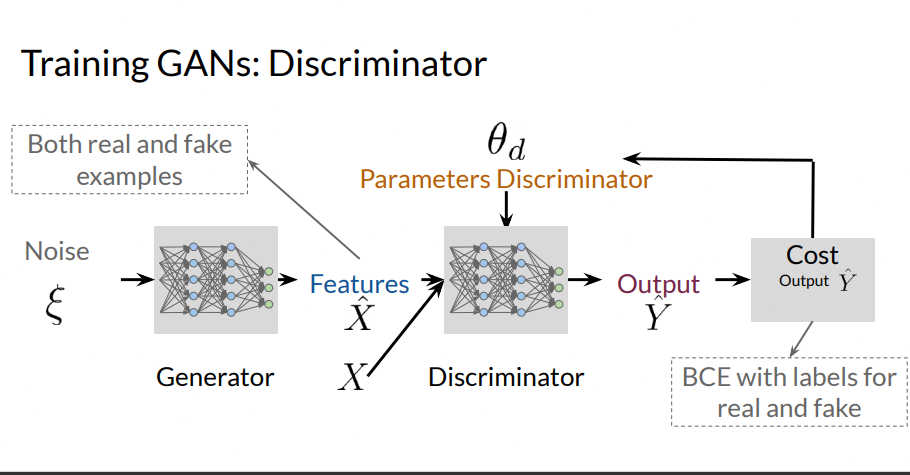

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 21, step(cur_step): Generator loss: 0.7117840837240218, discriminator loss: 0.6956283576488493


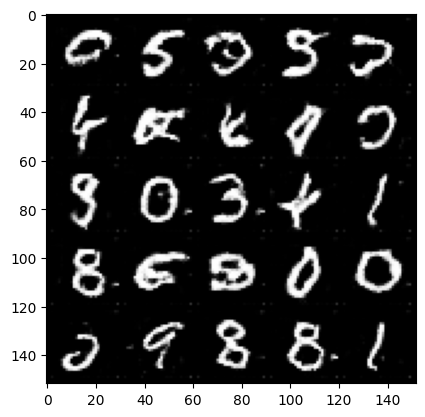

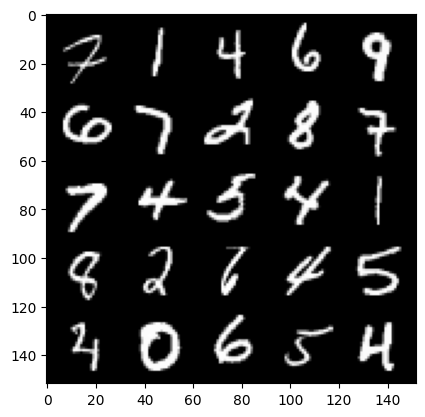

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 22, step(cur_step): Generator loss: 0.7148755012750622, discriminator loss: 0.6951988719701766


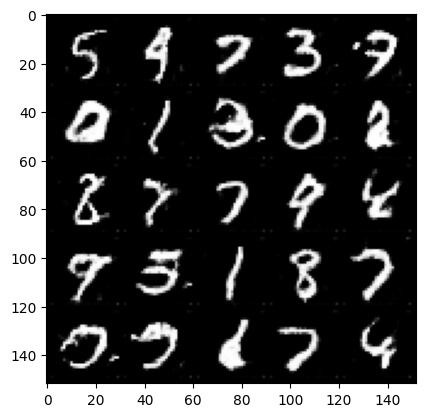

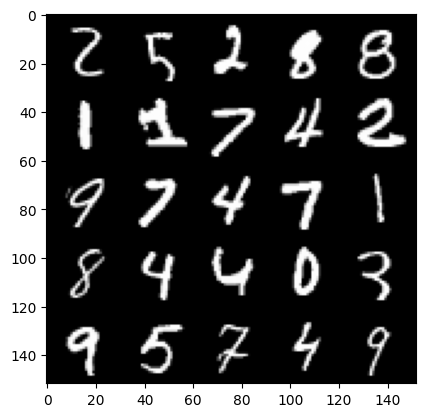

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 23, step(cur_step): Generator loss: 0.7096451906561855, discriminator loss: 0.6958396263122555


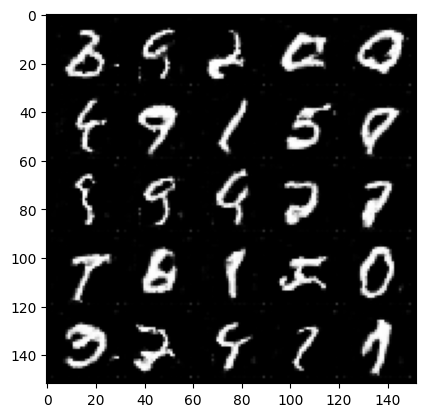

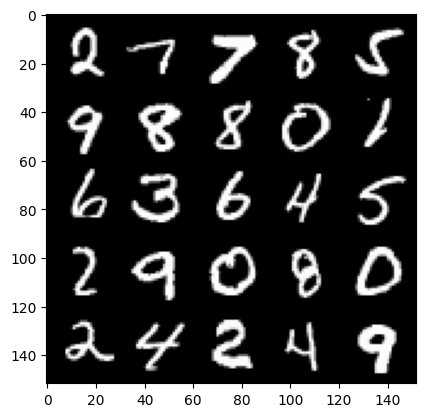

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 24, step(cur_step): Generator loss: 0.71240515756607, discriminator loss: 0.6954079278707505


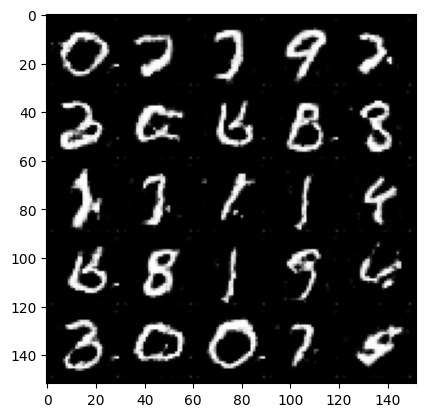

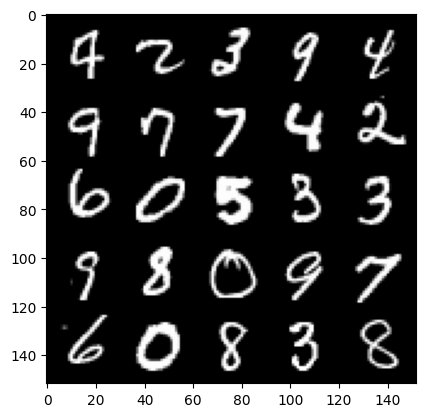

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

for epoch in range (n_epochs):
    # dataloader return the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        # Update discriminator@
        disc_opt.zero_grad()

        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))

        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        disc_loss.backward(retain_graph=True)
        disc_opt.step()


        # Update Generator@
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)

        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        # Visulization code

        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step(cur_step): Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

